In [15]:
import keras.backend as K
from keras.layers import Input, Add, Dense, Activation, Concatenate, Flatten, Dropout, Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D, TimeDistributed
from keras.models import Model
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.constraints import max_norm
from keras.layers.noise import GaussianNoise
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import operator
import matplotlib.pyplot as plt
import config
import importlib
import math
import os
import copy
import pandas as pd
import re
import numpy as np
import helper_fxns as hf
import transforms as tr
from scipy.misc import imsave
import tensorflow as tf
%matplotlib inline

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

nb_classes = C.nb_classes

X_train = np.expand_dims(x_train,axis=3)
X_train = np.expand_dims(X_train,axis=4)
X_test = np.expand_dims(x_test,axis=3)
X_test = np.expand_dims(X_test,axis=4)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [86]:
importlib.reload(config)
C = config.Config()

In [17]:
classes_to_include = ['cyst', 'hcc', 'hemangioma', 'colorectal', 'fnh', 'cholangio']

In [89]:
dims = C.dims
voi_img = Input(shape=(dims[0], dims[1], dims[2], C.nb_channels))
x = voi_img
#x = GaussianNoise(1)(x)
x = ZeroPadding3D(padding=(3,3,1))(voi_img)
x = Conv3D(filters=32, kernel_size=(3,3,1), activation='relu', kernel_constraint=max_norm(4.))(x)
x = Dropout(0.5)(x)
x = MaxPooling3D((2, 2, 1))(x)
x = Conv3D(filters=64, kernel_size=(3,3,2), activation='relu', kernel_constraint=max_norm(4.))(x)
x = Dropout(0.5)(x)
x = Conv3D(filters=64, kernel_size=(2,2,2), activation='relu', kernel_constraint=max_norm(4.))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_constraint=max_norm(4.))(x)#, kernel_initializer='normal', kernel_regularizer=l1(.01), kernel_constraint=max_norm(3.))(x)
x = Dropout(0.5)(x)
pred_class = Dense(C.nb_classes, activation='softmax')(x)#Dense(C.nb_classes, activation='softmax')(x)

In [90]:
optim = Adam(lr=0.01)#, decay=0.001)
early_stopping = EarlyStopping(min_delta=0.001, patience=10)

model = Model(voi_img, pred_class)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 24, 24, 12, 2)     0         
_________________________________________________________________
zero_padding3d_6 (ZeroPaddin (None, 30, 30, 14, 2)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 28, 28, 14, 32)    608       
_________________________________________________________________
dropout_18 (Dropout)         (None, 28, 28, 14, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 14, 14, 14, 32)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 12, 12, 13, 64)    36928     
_________________________________________________________________
dropout_19 (Dropout)         (None, 12, 12, 13, 64)    0         
__________

model2 = Model(voi_img, intermed)

for l in range(2,len(model2.layers)):
    model2.layers[l].set_weights(model.layers[l].get_weights())

In [71]:
orig_data_dict = {}
num_samples = {}

def collect_data(classes_to_include, C):
    for class_name in classes_to_include:
        x = np.empty((10000, C.dims[0], C.dims[1], C.dims[2], C.nb_channels))
        z = []

        for index, img_fn in enumerate(os.listdir(C.orig_dir+class_name)):
            try:
                x[index] = np.load(C.orig_dir+class_name+"\\"+img_fn)
            except:
                raise ValueError(C.orig_dir+class_name+"\\"+img_fn + " not found")
            z.append(img_fn)

        x.resize((index, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
        orig_data_dict[class_name] = [x,np.array(z)]
        num_samples[class_name] = index
        
    return orig_data_dict, num_samples

In [72]:
orig_data_dict, num_samples = collect_data(classes_to_include, C)
print(num_samples)

{'hcc': 63, 'cyst': 70, 'hemangioma': 40}


In [73]:
train_ids = {} #filenames of training set originals
test_ids = {} #filenames of test set
X_test = []
Y_test = []
Z_test = []
X_train_orig = []
Y_train_orig = []
Z_train_orig = []
cls_mapping = []

train_frac = {"cyst": .75, "fnh": .75, "hcc": .75, "hemangioma": .75, 'adenoma': .75, "colorectal": .75}
train_samples = {}

for cls_num, cls in enumerate(orig_data_dict):
    cls_mapping.append(cls)
    
    train_samples[cls] = round(num_samples[cls]*train_frac[cls])
    
    order = np.random.permutation(list(range(num_samples[cls])))
    train_ids[cls] = list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    test_ids[cls] = list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    
    X_test = X_test + list(orig_data_dict[cls][0][order[train_samples[cls]:]])
    Y_test = Y_test + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (num_samples[cls] - train_samples[cls])
    Z_test = Z_test + list(orig_data_dict[cls][1][order[train_samples[cls]:]])
    
    X_train_orig = X_train_orig + list(orig_data_dict[cls][0][order[:train_samples[cls]]])
    Y_train_orig = Y_train_orig + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * \
                        (train_samples[cls])
    Z_train_orig = Z_train_orig + list(orig_data_dict[cls][1][order[:train_samples[cls]]])
    
    print("%s has %d samples for training (%d after augmentation) and %d for testing" %
          (cls, train_samples[cls], train_samples[cls] * C.aug_factor[cls], num_samples[cls] - train_samples[cls]))

hcc has 47 samples for training (2350 after augmentation) and 16 for testing
cyst has 52 samples for training (2600 after augmentation) and 18 for testing
hemangioma has 30 samples for training (1500 after augmentation) and 10 for testing


In [74]:
train_samples

{'cyst': 52, 'hcc': 47, 'hemangioma': 30}

In [75]:
aug_data_dict = {}

for class_name in classes_to_include:#os.listdir(C.aug_dir):
    x_train = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    x_val = np.empty((10000, dims[0], dims[1], dims[2], C.nb_channels))
    z = []
    
    train_cnt = 0
    val_cnt = 0
    for img_fn in os.listdir(C.aug_dir+class_name):
        
        # part of training set
        if "_".join(img_fn.split("_")[:2])+".npy" in train_ids[class_name]:
            try:
                x_train[train_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                #continue
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            train_cnt += 1
            z.append(img_fn)
            
        else:
            try:
                x_val[val_cnt] = np.load(C.aug_dir+class_name+"\\"+img_fn)
            except:
                #continue
                raise ValueError(C.aug_dir+class_name+"\\"+img_fn + " cannot be loaded")
            val_cnt += 1
    
    x_train.resize((train_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    x_val.resize((val_cnt, dims[0], dims[1], dims[2], C.nb_channels)) #shrink first dimension to fit
    aug_data_dict[class_name] = {'train': [x_train,np.array(z)], 'val': x_val}

In [76]:
X_train = []
Y_train = []
Z_train = []
X_val = []
Y_val = []
Z_val = []

for cls_num, cls in enumerate(aug_data_dict):
    X_train = X_train + list(aug_data_dict[cls]['train'][0])
    Y_train = Y_train + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['train'][0])
    Z_train = Z_train + list(aug_data_dict[cls]['train'][1])
    
    X_val = X_val + list(aug_data_dict[cls]['val'])
    Y_val = Y_val + [[0] * cls_num + [1] + [0] * (C.nb_classes - cls_num - 1)] * len(aug_data_dict[cls]['val'])

Z_cyst = data_dict["cyst"][1]

Y_[-4]

Z_cyst[-4]

X_cyst = data_dict["cyst"][0]
X_cyst = np.array(X_cyst) # X[:total_size//2]
X_cyst /= 255

X_hcc = data_dict["hcc"][0]
X_hcc = np.array(X_hcc) # X[:total_size//2]
X_hcc /= 255

X_train = delete_channel(X_train)
X_val = delete_channel(X_val)
X_test = delete_channel(X_test)
X_train_orig = delete_channel(X_train_orig)

def delete_channel(X):
    return np.expand_dims(np.array(X)[:,:,:,:,0], axis=4)

In [77]:
def scale_to_one(X, scale_by_channel=False):
    X = np.array(X)
    def scale_img(x):
        return 1 * (x - np.amin(x)) / (np.amax(x) - np.amin(x)) - 0
    
    if scale_by_channel:
        X = [np.stack([scale_img(x[:,:,:,0]), scale_img(x[:,:,:,1])], axis=3) for x in X]
    else:
        X = [scale_img(x) for x in X]
    
    return np.array(X)

In [78]:
#scale from -1 to 1
X_train = scale_to_one(X_train)
X_val = scale_to_one(X_val)
X_test = scale_to_one(X_test)
X_train_orig = scale_to_one(X_train_orig)

Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_train_orig = np.array(Y_train_orig)

Z_train = np.array(Z_train)
Z_test = np.array(Z_test)
Z_train_orig = np.array(Z_train_orig)

In [28]:
#X = np.array([z for z in x])
#Y = np.array(y)
#Y = np.array([[0,1] if y[x] == 1 else [1,0] for x in range(len(y))])
#Y = K.constant(y, dtype=tf.int32)
#Y = K.one_hot(Y, C.nb_classes)

#total_size = X.shape[0]

#order = np.random.permutation(list(range(total_size)))
#X = X[order]
#Y = Y[order]

In [91]:
hist = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_data=(X_val, Y_val)) #callbacks=[early_stopping]

Train on 6105 samples, validate on 2225 samples
Epoch 1/200
6105/6105 [==============================] - 14s - loss: 1.0569 - acc: 0.4486 - val_loss: 0.9938 - val_acc: 0.6112
Epoch 2/200
6105/6105 [==============================] - 13s - loss: 0.7536 - acc: 0.6333 - val_loss: 0.6956 - val_acc: 0.6724
Epoch 3/200
6105/6105 [==============================] - 13s - loss: 0.6170 - acc: 0.7002 - val_loss: 0.6623 - val_acc: 0.6742
Epoch 4/200
6105/6105 [==============================] - 13s - loss: 0.5628 - acc: 0.7278 - val_loss: 0.6090 - val_acc: 0.6818
Epoch 5/200
6105/6105 [==============================] - 13s - loss: 0.5058 - acc: 0.7525 - val_loss: 0.6411 - val_acc: 0.6566
Epoch 6/200
6105/6105 [==============================] - 13s - loss: 0.4678 - acc: 0.7769 - val_loss: 0.5652 - val_acc: 0.7411
Epoch 7/200
6105/6105 [==============================] - 13s - loss: 0.4235 - acc: 0.8036 - val_loss: 0.5022 - val_acc: 0.7811
Epoch 8/200
6105/6105 [==============================] - 13s - 

6105/6105 [==============================] - 13s - loss: 0.0495 - acc: 0.9835 - val_loss: 0.5282 - val_acc: 0.8593
Epoch 65/200
6105/6105 [==============================] - 13s - loss: 0.0624 - acc: 0.9794 - val_loss: 0.2753 - val_acc: 0.9088
Epoch 66/200
1504/6105 [======>.......................] - ETA: 8s - loss: 0.0495 - acc: 0.9860

KeyboardInterrupt: 

def train_generator(X, Y):
    while True:
        for i in range(len(X)):
            yield np.expand_dims(X[i], axis=0), np.expand_dims(Y[i], axis=0)

num_epochs = 10
epoch_length = 100
best_loss = np.Inf
losses = np.zeros(epoch_length)
acc = np.zeros(epoch_length)

data_gen_train = train_generator(X_train, Y_train)
for epoch_num in range(num_epochs):
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
    iter_num = 0
    
    while True:
        X, Y = next(data_gen_train)
        losses[iter_num], acc[iter_num] = model.train_on_batch(X, Y)

        iter_num += 1
        if iter_num == epoch_length:
            curr_loss = np.mean(losses)
            curr_acc = np.mean(acc)
            print("Mean Loss:", curr_loss, "// Mean Accuracy:", curr_acc)

            if curr_loss < best_loss:
                print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model.save_weights(C.model_path)
            break

In [21]:
voi_df_art[voi_df_art["Filename"] == "12673726.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,dx,dy,dz,id
119,12673726.npy,105,134,76,101,40,53,hemangioma,True,29,25,13,126737261057640
120,12673726.npy,127,139,103,117,44,51,hemangioma,True,12,14,7,1267372612710344


In [22]:
voi_df_ven[voi_df_ven["id"] == "1267372612710344"]

,id,x1,x2,y1,y2,z1,z2,dx,dy,dz
74,1267372612710344,127,139,103,117,44,52,12,14,8


In [200]:
plot_2ch_with_bbox("E100738220_0.npy", "idk", pad=30, draw_bbox=True, save_dir="classified_imgs")

(293, 293, 75, 2)
(213, 213, 55, 2)


In [92]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)

In [81]:
def plot_2ch_with_bbox(fn, wrong_class, pad=15, draw_bbox=False, save_dir=None):
    z = re.search(r'^(.*)_(\d*)\.', fn)
    voi_df_ven["id"] = voi_df_ven["id"].astype(str)
    
    img_fn = z.group(1) + ".npy"
    voi = voi_df_art[voi_df_art["Filename"] == img_fn].iloc[int(z.group(2))]
    ven_voi = voi_df_ven[voi_df_ven["id"] == str(voi["id"])]
    
    img = np.load(C.full_img_dir+"\\"+img_fn)
    if len(ven_voi) > 0:
        img = hf.align(img, voi, ven_voi.iloc[0])
        
        
    crop_size = C.dims
    
    #pad_img, x1, x2, y1, y2, z1, z2 = get_
    exceed_ratio = max(voi['dx']/crop_size[0], voi['dy']/crop_size[1], voi['dz']/crop_size[2]) / 1
    if exceed_ratio > 1:# or exceed_ratio < 0.7:
        #if exceed_ratio < 0.7:
        #    exceed_ratio += 0.15
            
        img = tr.scale3d(img, [1/exceed_ratio]*3)
        x1 = round(voi['x1'] / exceed_ratio)
        x2 = round(voi['x2'] / exceed_ratio)
        y1 = round(voi['y1'] / exceed_ratio)
        y2 = round(voi['y2'] / exceed_ratio)
        z1 = round(voi['z1'] / exceed_ratio)
        z2 = round(voi['z2'] / exceed_ratio)
    else:
        x1 = voi['x1']
        x2 = voi['x2']
        y1 = voi['y1']
        y2 = voi['y2']
        z1 = voi['z1']
        z2 = voi['z2']
        
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
        
    xpad = max(crop_size[0] - dx,0)
    ypad = max(crop_size[1] - dy,0)
    zpad = max(crop_size[2] - dz,0)

    side_padding = math.ceil(max(xpad, ypad, zpad) / 2)

    pad_img = []

    for ch in range(img.shape[-1]):
        pad_img.append(np.pad(img[:,:,:,ch], side_padding, 'constant'))

    pad_img = np.stack(pad_img, axis=3)

    x1 += side_padding - math.ceil(xpad/2)
    x2 += side_padding + math.floor(xpad/2)
    y1 += side_padding - math.ceil(ypad/2)
    y2 += side_padding + math.floor(ypad/2)
    z1 += side_padding - math.ceil(zpad/2)
    z2 += side_padding + math.floor(zpad/2)
    
    x1=int(x1)
    x2=int(x2)
    y1=int(y1)
    y2=int(y2)
    z1=int(z1)
    z2=int(z2)

    slice_num = (z1+z2)//2
    img_slice = pad_img[:,:, slice_num, :]
    img_slice[:, :, 0] *= 255/np.amax(img_slice[:, :, 0])
    img_slice[:, :, 1] *= 255/np.amax(img_slice[:, :, 1])
    img_slice = np.stack([img_slice, img_slice, img_slice], axis=2)
    
    if draw_bbox:
        if False:
            img_slice[df['x1']:df['x2'], df['y2'], 0, :] = 255
            img_slice[df['x1']:df['x2'], df['y2'], 1:, :] = 0

            img_slice[df['x1']:df['x2'], df['y1'], 0, :] = 255
            img_slice[df['x1']:df['x2'], df['y1'], 1:, :] = 0

            img_slice[df['x1'], df['y1']:df['y2'], 0, :] = 255
            img_slice[df['x1'], df['y1']:df['y2'], 1:, :] = 0

            img_slice[df['x2'], df['y1']:df['y2'], 0, :] = 255
            img_slice[df['x2'], df['y1']:df['y2'], 1:, :] = 0
        
        img_slice[x1:x2, y2, 2, :] = 255
        img_slice[x1:x2, y2, :2, :] = 0
        
        img_slice[x1:x2, y1, 2, :] = 255
        img_slice[x1:x2, y1, :2, :] = 0
        
        img_slice[x1, y1:y2, 2, :] = 255
        img_slice[x1, y1:y2, :2, :] = 0
        
        img_slice[x2, y1:y2, 2, :] = 255
        img_slice[x2, y1:y2, :2, :] = 0
        
    if save_dir is None:
        plot_section_2ch(img_slice, [x1,x2,y1,y2], fn, pad=pad)
    else:
        plot_section_2ch(img_slice, [x1,x2,y1,y2], fn, save_dir=save_dir+"\\"+voi['cls'], wrong_class=wrong_class, pad=pad, noshow=True)

In [82]:
def plot_section_2ch(img_slice, coords, fn, save_dir=None, wrong_class=None, pad=15, noshow=False):
    #plt.subplot(121)
    if noshow:
        ch1 = np.transpose(get_cropped_slice(img_slice[:,:,:,0], coords, pad), (1,0,2))
        ch2 = np.transpose(get_cropped_slice(img_slice[:,:,:,1], coords, pad), (1,0,2))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        ret = np.empty([ch1.shape[0]*2, ch1.shape[1], 3])
        ret[:ch1.shape[0],:,:] = ch1
        ret[ch1.shape[0]:,:,:] = ch2
        imsave("%s\\%s (pred %s).png" % (save_dir, fn[:-3], wrong_class), ret)
        
    else:
        return None

In [83]:
def get_cropped_slice(img_slice, coords, pad):
    x1 = max(coords[0]-pad, 0)
    x2 = min(coords[1]+pad, img_slice.shape[0])
    y1 = max(coords[2]-pad, 0)
    y2 = min(coords[3]+pad, img_slice.shape[1])
    
    return img_slice[x1:x2, y2:y1:-1]

In [93]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

save_dir = "classified_imgs"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(save_dir + "\\correct"):
    os.makedirs(save_dir + "\\correct")
else:
    print("images may already exist...")
if not os.path.exists(save_dir + "\\incorrect"):
    os.makedirs(save_dir + "\\incorrect")
    
for i in range(len(Z_test)):
    if y_pred[i] != y_true[i]:
        plot_2ch_with_bbox(Z_test[i], cls_mapping[y_pred[i]], pad=30, draw_bbox=True, save_dir=save_dir + "\\incorrect")
    else:
        plot_2ch_with_bbox(Z_test[i], cls_mapping[y_pred[i]], pad=30, draw_bbox=True, save_dir=save_dir + "\\correct")  

In [94]:
Y_pred = model.predict(X_train_orig)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

for i in range(len(Z_train_orig)):
    if y_pred[i] != y_true[i]:
        plot_2ch_with_bbox(Z_train_orig[i], cls_mapping[y_pred[i]], pad=30, draw_bbox=True, save_dir=save_dir + "\\incorrect")
    else:
        plot_2ch_with_bbox(Z_train_orig[i], cls_mapping[y_pred[i]], pad=30, draw_bbox=True, save_dir=save_dir + "\\correct") 

In [20]:
cls_mapping

['cyst', 'hcc', 'hemangioma']

In [19]:
cm

array([[15,  0,  3],
       [ 2,  9,  1],
       [ 1,  0, 10]], dtype=int64)

In [25]:
accuracy_score(y_true, y_pred)

0.82926829268292679

def plot_1ch_with_bbox(fn, wrong_class, pad=15, draw_bbox=False, save_dir=None):
    voi_df = pd.read_csv('vois.csv')
    z = re.search(r'^(.*)_(\d*)\.', fn)
    
    img_fn = z.group(1) + ".npy"
    df = voi_df[voi_df["Filename"] == img_fn].iloc[int(z.group(2))]
    
    img = np.load("full_imgs\\"+img_fn)
    #if
    slice_num = (df['z1']+df['z2'])//2
    img_slice = img[:,:, slice_num, 0]
    img_slice = np.stack([img_slice, img_slice, img_slice], axis=2)
    
    if draw_bbox:
        img_slice[df['x1']:df['x2'], df['y2'], 0] = 1
        img_slice[df['x1']:df['x2'], df['y2'], 1:] = 0
        
        img_slice[df['x1']:df['x2'], df['y1'], 0] = 1
        img_slice[df['x1']:df['x2'], df['y1'], 1:] = 0
        
        img_slice[df['x1'], df['y1']:df['y2'], 0] = 1
        img_slice[df['x1'], df['y1']:df['y2'], 1:] = 0
        
        img_slice[df['x2'], df['y1']:df['y2'], 0] = 1
        img_slice[df['x2'], df['y1']:df['y2'], 1:] = 0
        
    if save_dir is None:
        plot_section(img_slice, df, fn, pad=pad)
    else:
        plot_section(img_slice, df, fn, save_dir=save_dir+"\\"+df['cls'], wrong_class=wrong_class, pad=pad, noshow=True)

In [365]:
fn_list = Z_test[~np.equal(y_pred, y_true)]
wrong_guesses = np.array(y_pred)[~np.equal(y_pred, y_true)]

def plot_section(img_slice, row, fn, save_dir=None, wrong_class=None, pad=15, noshow=False):
    #plt.subplot(121)
    if noshow:
        ret = np.transpose(get_cropped_slice(img_slice, row, pad), (1,0,2))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        imsave("%s\\%s (pred %s).png" % (save_dir, fn[:-3], wrong_class), ret)
        
    else:
        ret = np.transpose(get_cropped_slice(img_slice[:,:,0], row, pad), (1,0))
        plt.imshow(ret, cmap='gray')
    #plt.subplot(122)

In [409]:
Z_test[~np.equal(y_pred, y_true)]

array(['E100815762_0.npy', '12239513_0.npy', '12042703_2.npy'],
      dtype='<U16')

In [380]:
Z_test

array(['E105152534_0.npy', '13166464_0.npy', '12789019_1.npy',
       'E103514998_0.npy', 'E104430882_0.npy', '13064153_0.npy',
       '12857716_0.npy', '13064153_1.npy', 'E100718398_0.npy',
       'E101636006_0.npy', 'E105464882_0.npy', '12239513_0.npy',
       '12229245_0.npy', '12302576_2.npy', '12302576_0.npy'],
      dtype='<U16')

In [443]:
voi_df = pd.read_csv('vois.csv')
img_fn = "E100262351.npy"
img = np.load("full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=5)

ValueError: axes don't match array

In [159]:
activ = model2.predict(X_train)
#activ = model2.predict(np.expand_dims(X_train[10],axis=0))

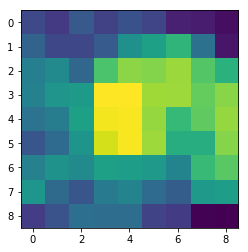

In [166]:
plt.imshow(activ[20][:,:,3,5])

In [162]:
activ[0][5,5,2,:]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  121.71251678,   53.23372269,    0.        ,
          0.        ,   24.43340492,    0.        ,    0.        ,
          0.        ,    0.        ,    7.88301706,    0.        ], dtype=float32)

In [316]:
import operator
#print("Ground truth:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] for x in Y_val[::30]])
Y_ = model.predict(X_test)
print("Predictions:", [cls_mapping[max(enumerate(x), key=operator.itemgetter(1))[0]] + " (%.5f%% confidence)" % (max(x)*100) for x in Y_])

Predictions: ['hcc (95.75861% confidence)', 'hcc (99.98515% confidence)', 'hcc (56.77554% confidence)', 'hcc (97.68384% confidence)', 'hcc (96.73136% confidence)', 'hcc (99.99979% confidence)', 'hcc (99.99988% confidence)', 'hcc (99.71866% confidence)', 'cyst (63.61439% confidence)', 'cyst (51.41591% confidence)', 'hcc (99.65365% confidence)', 'hcc (52.72004% confidence)', 'hcc (57.44457% confidence)', 'cyst (99.82330% confidence)', 'cyst (83.69393% confidence)']


In [20]:
Y_[-1]

array([  2.78843247e-04,   9.99721110e-01], dtype=float32)

In [19]:
max(sum(y)/len(y), 1-sum(y)/len(y))

0.6875

In [87]:
len(X_val)

210

In [84]:
import time

In [86]:
a=time.time()
Y_ = model.predict(X_val)
print(time.time()-a)

0.20054101943969727


In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
np.amax(X[650,:,:,:,0])

0.0

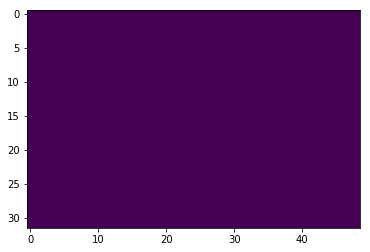

In [140]:
plt.imshow(X[0,:,:,5,0])